In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gzip
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import scipy
import multiprocessing

In [2]:
year = 2019
zfilln = 3 # for file names  

# set directories for results and comb contents
resultsdir = '/Volumes/JD-SSD/bees/beeresults2019/'
comb_contents_dir = '/Volumes/JD-SSD/bees/comb-contents-images2019/'
    
# If the files 'datafunctions.py', 'definitions_2019.py', and 'displayfunctions.py' are in a different folder, need to cd there so can import them
#%cd 'directory-with-py-files'

import definitions_2019 as bd  
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
# import data_and_embedding
dfunc.init(bd) 
bp.init(bd)
# import data_and_embedding2019 as de  # data_and_embedding2019.py
bd.year

2019

# Read in data and plot

In [3]:
controldays = bd.heatdays[1:] - 1
treatmentdays = bd.heatdays[1:]
control_day_with_blocking = 86 # so I can remember to treat this one differently
treatment_day_nocontrol = 87
controldays = np.delete(controldays,np.where(controldays==control_day_with_blocking)[0])
controldays,treatmentdays

(array([78, 80, 92, 95]), array([79, 81, 87, 93, 96]))

In [4]:
numtimedivs=288 # 24->1 hour, 288->5 min, 1440->1 min
days_to_load = [78,79,80,81,86,87,92,93,95,96]

if numtimedivs==24:
    prefix = 'dayhour'
elif numtimedivs==288:
    prefix = 'day5min'
elif numtimedivs==1440: 
    prefix = 'day1min'
else: 
    print('ERROR:  use either numtimedivs == 24 or 288 or 1440')

for i,daynum in enumerate(days_to_load):
    filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.hdf'
    if i==0:
        df_sub = pd.read_hdf(filename)
    else:
        df_sub = pd.concat((df_sub,pd.read_hdf(filename) ))  

In [5]:
df_sub.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'Mean x-shifted', 'Mean y', 'Bee unique ID', 'Cohort ID',
       'Num. outside trips', 'Num. dance floor visits',
       'Dispersion-minute avg.', 'Frame 0 - Num. crossings',
       'Frame 1 - Num. crossings', 'Frame 2 - Num. crossings',
       'Frame 3 - Num. crossings', 'Frame 4 - Num. crossings',
       'Frame 5 - Num. crossings', 'timedivision'],
      dtype='object')

In [6]:
datacolnames = ['Num. observations','Honey', 'Brood care', 'Other','Frame 5','Pollen',
                  'Median speed', 'Fraction squares visited','Dispersion (avg)','Exit distance (median)']
datamat_all_heat_days = [np.array(df_sub[df_sub['Day number'] == i][datacolnames]) for i in days_to_load]

## Total bees

In [7]:
total_bees = [len(df_sub[df_sub['Day number'] == i]['Bee unique ID'].unique()) for i in days_to_load]
total_bees

[2009, 1971, 1893, 1852, 2281, 2211, 2378, 2360, 2297, 2279]

## Time divisions

In [8]:
timedivs = [df_sub[df_sub['Day number'] == i]['timedivision'] for i in days_to_load]

In [9]:
hourstart = 0
hourend = 24
timebins = np.arange(hourstart*12,hourend*12+1) 

In [61]:
# [day,metric,timebin]
mean_quantity = np.tile(np.nan,(len(days_to_load),len(datacolnames),len(timebins)-1))
for i in range(len(days_to_load)):
    for j in range(len(datamat_all_heat_days)):
        mean_quantity[i,j] = scipy.stats.binned_statistic(timedivs[i],datamat_all_heat_days[i][:,j],bins=timebins,statistic=(lambda x: np.nanmean(x)))[0] 
# mean_quantity = [[scipy.stats.binned_statistic(timedivs[j],datamat_all_heat_days[j][:,i],bins=timebins,statistic=(lambda x: np.nanmean(x)))[0] 
#                 for i in range(9)]
#                    for j in range(len(datamat_all_heat_days))]

## Number of bees outside

In [11]:
# compute time outside, can use parallel computation
exitdistthreshold = 1500
def fnoutsidehour(daynum):
    filename = resultsdir+'df_'+'day1min'+'_'+str(daynum).zfill(zfilln)+'.hdf'
    dfday = pd.read_hdf(filename)
    day_uids, day_ages, all_inhive, bee_obs, _ , _ = dfunc.get_inout_estimates(dfday, obs_threshold=5,exitdistthreshold=exitdistthreshold,
                                                                           numtimedivs=1440)
    permin_outside = all_inhive==0
    return permin_outside

# outsideresults_bee = list(map(fnoutsidehour,days_to_load))

In [12]:
pool = multiprocessing.get_context("fork").Pool(processes=10)
outsideresults_bee = pool.map(fnoutsidehour, days_to_load)
pool.close()

In [62]:
## number of bees outside over time
numbees_over_time_all_days = [np.sum(permin_outside,axis=0) for permin_outside in outsideresults_bee]
# simple summing over an interval of 5 mins
mins = np.arange(0,len(numbees_over_time_all_days[0]))
# num_bees_outside_5_min = np.array([scipy.stats.binned_statistic(mins,numbees,statistic=(lambda x: np.nanmean(x)),bins=288,range = (0,len(mins)))[0] for numbees in numbees_over_time_all_days])

num_bees_outside_5_min = np.zeros_like(mean_quantity[:,0,:])
for i,numbees in enumerate(numbees_over_time_all_days):
    num_bees_outside_5_min[i],bins,_ = scipy.stats.binned_statistic(mins,numbees,statistic=(lambda x: np.nanmean(x)),bins=timebins*5)

In [64]:
# remove the measurement period, which is visible to be, when observations have all nans
for i in range(len(days_to_load)):
    allnans = np.isnan(mean_quantity[i][0])
    nanmult = np.ones(allnans.shape)
    nanmult[allnans] = np.nan
    if np.sum(allnans)>0:
        nanmult[np.where(allnans)[0][[0,-1]]] = np.nan
    # remove the time bin before and after the nans, because it likely also coincided with the measurement period
    mean_quantity[i] = mean_quantity[i]*(nanmult[np.newaxis,:])
    num_bees_outside_5_min[i] = num_bees_outside_5_min[i]*nanmult

### plots for whole day

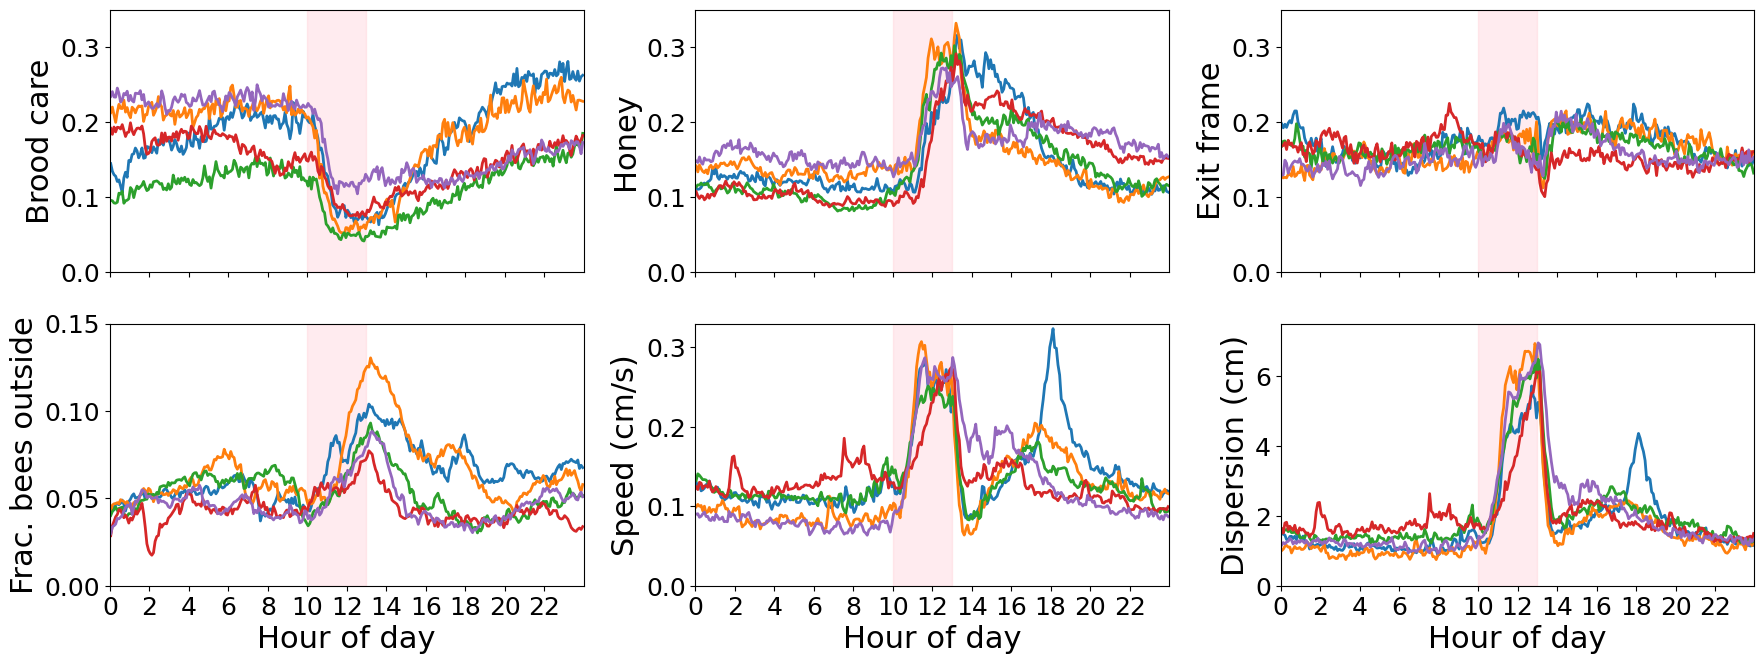

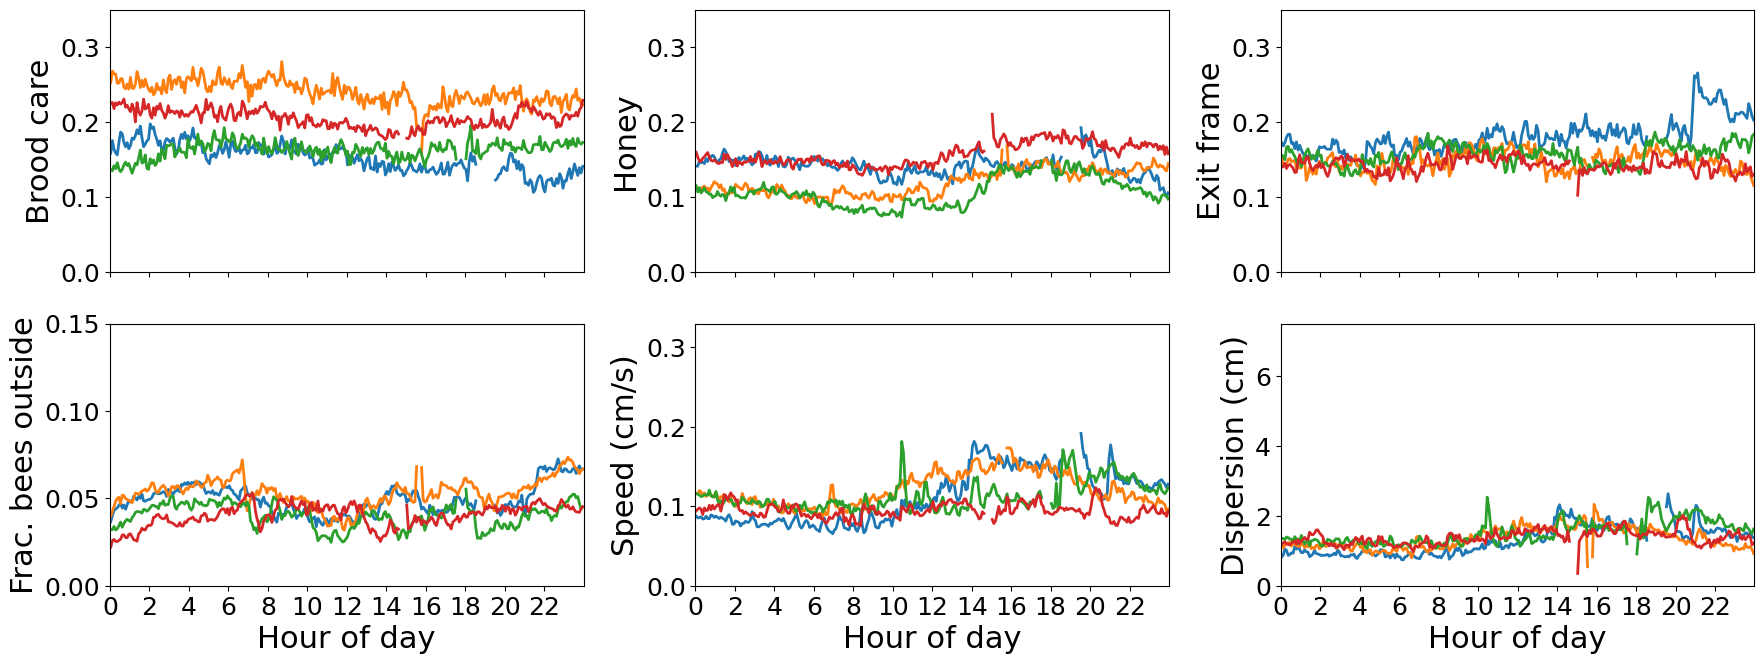

In [54]:
labelfontsize = 22
ticklabelfontsize = 18
plotcolnames = ['Num. observations','Honey', 'Brood care', 'Other','Exit frame','Pollen',
                  'Speed (cm/s)', 'Fr. squares visited','Dispersion (cm)','Exit distance']

dayinds_heat = [1,3,5,7,9]
dayinds_control = [0,2,6,8]
ci_heat = np.arange(5)
ci_control = [0,1,3,4]

for dayinds,label,cinds in zip([dayinds_heat,dayinds_control],['Heat stress','Control days'],[ci_heat,ci_control]):

    f,ax = plt.subplots(2,3,sharex=True)
    f.set_facecolor('white')
    f.set_size_inches([18,7])
    for j,i in enumerate([2,1,4,6,8]):
        x,y = np.divmod(j,3)
        if x == 1:
            y+=1
        a=ax[x,y]
        y_min = np.nanmin([mean_quantity[day][i] for day in dayinds])
        y_max = np.nanmax([mean_quantity[day][i] for day in dayinds])
        a.set_ylim([y_min, y_max + y_max*0.1])
        for colorind,k in enumerate(dayinds):
            if (i == 6) or (i == 8):
                a.plot(timebins[0:-1]+0.5,mean_quantity[k][i]/bd.pixels_per_cm,linewidth=2)
                # a.set_ylim([y_min/bd.pixels_per_cm, (y_max + y_max*0.1)/bd.pixels_per_cm])
            else:
                a.plot(timebins[0:-1]+0.5,mean_quantity[k][i],linewidth=2)
        if x == 0:  # use same limits for top row
            a.set_ylim([0,0.35])
            # a.set_yticks(np.arange(0.05,0.35,0.1))
        elif x == 1:
            if i == 6:  # speed
                a.set_yticks(np.arange(0,0.35,0.10))
                a.set_yticklabels(np.round(a.get_yticks(),2),fontsize=ticklabelfontsize)
                a.set_ylim([0,0.33])
            elif i == 8:  # dispersion
                a.set_ylim([0,7.5])
        a.set_ylabel(plotcolnames[i],fontsize=labelfontsize)

    # Fraction bees outside - treat this separately
    a=ax[1,0]
    for colorind,i in enumerate(dayinds):
        a.plot(timebins[0:-1]+0.5,num_bees_outside_5_min[i][hourstart*12:hourend*12] / total_bees[i],linewidth=2)
    a.set_ylabel('Frac. bees outside',fontsize=labelfontsize)
    a.set_xlabel('Time of day',fontsize=labelfontsize)
    # a.set_yticks([0,0.05,0)
    a.set_ylim([0,0.15])

    # formatting
    for a in ax.flatten():
        if label=='Heat stress':
            a.axvspan(10*12,13*12,alpha=0.3,color='pink')
        a.set_xticks(np.arange(hourstart*12,hourend*12,24))
        a.tick_params(labelsize=ticklabelfontsize)
        a.set_xticklabels(np.arange(0,24,2),fontsize=ticklabelfontsize)
        a.set_xlim([timebins[0],timebins[-1]])
        
    for a in ax[1]:
        a.set_xlabel('Hour of day',fontsize=labelfontsize)
        a.set_xticks(np.arange(hourstart*12,hourend*12,24))#[108,120,132,144,156,168])
        a.set_xticklabels(np.arange(0,24,2),fontsize=ticklabelfontsize)


    legendtext = [('Day before\n' if label=='Control days' else '')+'Trial '+str(k+1) for k in cinds]
    # ax[1,2].legend(legendtext,bbox_to_anchor=(1,1),fontsize=labelfontsize)
    # Day before 

    plt.tight_layout(pad=2)
    plt.savefig('../image-output/fig2-time-series-trends-24h'+label+'.pdf')
    plt.show()